In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
import sys
sys.path.append("..")

from dataloaders.dataloader_v1 import get_loader
import torch
from wcmatch.pathlib import Path
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from matplotlib import pyplot as plt
from einops import rearrange, repeat
import cv2
import numpy as np
import random
import time
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio

root = "/hdd_mnt/onurcan/onurk/datasets/"
stage = "test"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

large

In [3]:
import torch
from utils.utils import zero_padding_twice, fft2d, ifft2d
from utils.algorithms import apply_image_constraint_hio
from models.denoisers import get_denoiser

class End2End(torch.nn.Module):
    def __init__(
        self,
        device: torch.device,
        total_iterations: int = 12,
        total_dc_iterations: int = 5,
        denoiser_architecture: str = "FBPConvNet",
    ):
        super().__init__()

        self.denoiser = get_denoiser(denoiser_architecture)().to(device)

        self.lam = torch.nn.Parameter(
            torch.logspace(-0.11, -1.9, total_iterations).to(device)
        )  # 1....0.125 from the thesis, lam should be [0,1]
        
        self.total_iterations = total_iterations
        self.total_dc_iterations = total_dc_iterations
        self.beta = 0.9
        self.alpha = 3.0

    def forward(self, hio_output, amplitude, support, total_time_steps = None, last_iterations_to_train = 1):
        total_time_steps = total_time_steps or self.total_iterations

        assert total_time_steps <= self.total_iterations, "total_time_steps should be smaller than total_iterations"
        assert last_iterations_to_train <= total_time_steps, "last_iterations_to_train should be smaller than total_time_steps"
            
        x_ = hio_output # B, 10, W, H
        
        self.denoiser.eval()
        with torch.no_grad():
            for i in range(total_time_steps - last_iterations_to_train):
                z_ = self.denoiser(x_ / 255.0, i) * 255.0 # B, 5, W, H
                z_ = torch.clamp(z_, min=0.0, max=255.0)
                
                x_ = self.dc(z_, amplitude, i, support)
                
                if (i == total_time_steps - 1) and (last_iterations_to_train == 0):
                    return [z_]
                
                x_ = torch.cat([x_, z_], dim=1)
                
                x_ = x_ + self.lam[i] * torch.randn_like(x_) * self.alpha * self.alpha

        self.denoiser.train()
        output_list = []
        for i in range(total_time_steps - last_iterations_to_train, total_time_steps):
            z_ = self.denoiser(x_ / 255.0, i) * 255.0
            z_ = torch.clamp(z_, min=0.0, max=255.0)
            
            output_list.append(z_) # normalize(x_)
            
            x_ = self.dc(z_, amplitude, i, support)
            
            output_list.append(x_) # normalize(x_)
            
            x_ = torch.cat([x_, z_], dim=1) # before z_ x_
            
            x_ = x_ + self.lam[i] * torch.randn_like(x_) * self.alpha * self.alpha

        return output_list

    def dc(self, z, b, i, support):
        z_k = zero_padding_twice(z)
        z_0 = z_k
        
        y_new = self.lam[i] * b + (1 - self.lam[i]) * fft2d(z_0).abs()

        for _ in range(self.total_dc_iterations):
            Fz = fft2d(z_k)
            # x_kprime = ifft2d(torch.polar(self.lam[i] * b + (1 - self.lam[i]) * Fz.abs(), Fz.angle())).real
            # x_kprime = self.lam[i] * ifft2d(torch.polar(b, Fz.angle())).real + (1 - self.lam[i]) * z_0
            x_kprime = ifft2d(torch.polar(y_new, Fz.angle())).real
            z_k = apply_image_constraint_hio(x_kprime, z_k, support, beta=self.beta)

        return crop_center_half(z_k)

In [4]:
total_iterations = 18
denoiser_architecture = "UNet2DMulti"

end2end_model = End2End(device=device, total_iterations=total_iterations, denoiser_architecture=denoiser_architecture)
adversarial_denoiser = get_denoiser("UNet2DMultiLargeAdversarialNoFreq")().to(device)
loss = torch.nn.MSELoss()

small

In [5]:
import torch
from utils.utils import zero_padding_twice, fft2d, ifft2d
from utils.algorithms import apply_image_constraint_hio
from models.denoisers import get_denoiser

class End2EndSmall(torch.nn.Module):
    def __init__(
        self,
        device: torch.device,
        total_iterations: int = 12,
        total_dc_iterations: int = 5,
        denoiser_architecture: str = "FBPConvNet",
    ):
        super().__init__()

        self.denoiser = get_denoiser(denoiser_architecture)().to(device)

        self.lam = torch.nn.Parameter(
            torch.logspace(-0.15, -2.9, total_iterations).to(device)
        )  # 1....0.125 from the thesis, lam should be [0,1]
        
        self.total_iterations = total_iterations
        self.total_dc_iterations = total_dc_iterations
        self.beta = 0.9
        self.alpha = 3.0

    def forward(self, hio_output, amplitude, support, total_time_steps = None, last_iterations_to_train = 1):
        total_time_steps = total_time_steps or self.total_iterations

        assert total_time_steps <= self.total_iterations, "total_time_steps should be smaller than total_iterations"
        assert last_iterations_to_train <= total_time_steps, "last_iterations_to_train should be smaller than total_time_steps"
            
        x_ = hio_output
        
        self.denoiser.eval()
        with torch.no_grad():
            for i in range(total_time_steps - last_iterations_to_train):
                z_ = self.denoiser(x_ / 255.0, i) * 255.0
                z_ = torch.clamp(z_, min=0.0, max=255.0)
                x_ = self.dc(z_, amplitude, i, support)
                if (i == total_time_steps - 1) and (last_iterations_to_train == 0):
                    return [z_, x_]
                x_ = x_ + self.lam[i] * torch.randn_like(x_) * self.alpha * self.alpha

        self.denoiser.train()
        output_list = []
        for i in range(total_time_steps - last_iterations_to_train, total_time_steps):
            z_ = self.denoiser(x_ / 255.0, i) * 255.0
            output_list.append(z_) # normalize(x_)
            z_ = torch.clamp(z_, min=0.0, max=255.0)
            x_ = self.dc(z_, amplitude, i, support)
            output_list.append(x_) # normalize(x_)
            x_ = x_ + self.lam[i] * torch.randn_like(x_) * self.alpha * self.alpha

        return output_list

    def dc(self, z, b, i, support):
        z_k = zero_padding_twice(z)
        z_0 = z_k

        for _ in range(self.total_dc_iterations):
            Fz = fft2d(z_k)
            # x_kprime = ifft2d(torch.polar(self.lam[i] * b + (1 - self.lam[i]) * Fz.abs(), Fz.angle())).real
            x_kprime = ifft2d(torch.polar(self.lam[i] * b, Fz.angle())).real + (1 - self.lam[i]) * z_0
            z_k = apply_image_constraint_hio(x_kprime, z_k, support, beta=self.beta)

        return crop_center_half(z_k)

In [6]:
total_iterations = 18
denoiser_architecture = "UNet2D"

end2end_model_small = End2EndSmall(device=device, total_iterations=total_iterations, denoiser_architecture=denoiser_architecture)
loss = torch.nn.MSELoss()

inference

In [7]:
# large
end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_last_amax_newwithcorrectsnr_2__largenew_betterdc.pth"))
adversarial_denoiser.load_state_dict(torch.load("save_adversarial_alpha_3_best_large_new_________.pth"))

# small
end2end_model_small.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_best_amax_newwithcorrectsnr.pth"))

<All keys matched successfully>

In [9]:
from tqdm import tqdm
import time
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio
import logging
import pickle
from einops import reduce

filename = "notebooks/large_small_inference__"

In [10]:
test_dataloader = get_loader("noise_amplitude_dataset", stage, root, batch_size=1, alpha=3, return_noiseless=True) # dont change the batch size for this script

In [11]:
def save_fig(image, save_index, save_index_monte_carlo, save_psnr, save_ssim, save_snr, save_description):
    plt.imshow(image[0, 0].cpu(), cmap="gray")
    plt.axis("off")
    plt.savefig(f"/hdd_mnt/onurcan/onurk/notebooks/example_test_result_large_small/{save_index}_{save_index_monte_carlo}_{save_description}_{save_psnr:.3f}_{save_ssim:.3f}_{save_snr:.3f}.pdf", bbox_inches='tight', dpi=300, pad_inches=0)

In [12]:
logging.basicConfig(level=logging.INFO, filename=f"{filename}.log", filemode="w", format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

end2end_model.eval()
adversarial_denoiser.eval()
with torch.no_grad():
    # epoch_mean_metrics = []
    all_metrics = []

    for i_montecarlo in range(5):
        epoch_metrics = {
            # "mse_hio": np.array([]),
            # "mse_initialization": np.array([]),
            # "mse_developed": np.array([]),
            
            "snr_dataset": np.array([]),
            
            "psnr_hio": np.array([]),
            "psnr_initialization": np.array([]),
            "psnr_developed": np.array([]),
            "psnr_developed_large": np.array([]),
            "psnr_developed_large_tta_0": np.array([]),
            "psnr_developed_large_tta_1": np.array([]),
            "psnr_developed_large_tta_mean": np.array([]),
            "psnr_initialization_small": np.array([]),
            "psnr_developed_small": np.array([]),
            
            "ssim_hio": np.array([]),
            "ssim_initialization": np.array([]),
            "ssim_developed": np.array([]),
            "ssim_developed_large": np.array([]),
            "ssim_developed_large_tta_0": np.array([]),
            "ssim_developed_large_tta_1": np.array([]),
            "ssim_developed_large_tta_mean": np.array([]),
            "ssim_initialization_small": np.array([]),
            "ssim_developed_small": np.array([]),
            
            "time_hio": np.array([]),
            "time_initialization": np.array([]),
            "time_developed": np.array([]),
            "time_developed_large": np.array([]),
            "time_developed_tta": np.array([]),
            "time_initialization_small": np.array([]),
            "time_developed_small": np.array([]),
        }

        test_i = 0
        #for im, am, sp, robust_output in tqdm(test_dataloader):
        for im, am, sp, am_noiseless in tqdm(test_dataloader):
            if test_i < 144:
                test_i += 1
                continue
            im = im.to(device)
            am = am.to(device)
            sp = sp.to(device)
            # robust_output = robust_output.to(device).float()
            
            # snr calculation
            snr = 10*torch.log10(torch.norm(am_noiseless ** 2) / torch.norm(am.cpu() ** 2 - am_noiseless ** 2)).item()
            epoch_metrics["snr_dataset"] = np.append(epoch_metrics["snr_dataset"], snr)
            
            #############
            
            # HIO method
            start_hio = time.time()
            
            g, _ = get_algorithm("HIO")(am, sp, use_tqdm=False, iteration=1000)
            im_cropped_normalized = normalize(crop_center_half(im)) # normalize decreases the metrics
            g_cropped_normalized = normalize(crop_center_half(g))
            all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized)
            hio_output = all_mse_loss_corrected[0] * 255
            
            end_hio = time.time()
            
            #############
            
            # Developed algorithm - prNet - Large
            start_developed = time.time()
            
            top_k = 10
            g, _ = get_algorithm("MultiOutputRobustHIO")(am, sp, different_random_count=100, top_k=top_k, use_tqdm=False)
            end_time = time.time()
            # print(f"Time: {end_time - start_time}")

            im_cropped_normalized = crop_center_half(im) # normalize decreases the metrics
            g_cropped_normalized = crop_center_half(g)
            
            im_cropped_normalized_repeated = repeat(
                im_cropped_normalized, "b c h w -> b (repeat c) h w", repeat=top_k
            )

            all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized_repeated)
            robust_output = all_mse_loss_corrected[0] # * 255
            robust_output = robust_output.to(device).float()
            
            # clip between 0-255
            robust_output = torch.clip(robust_output, 0, 255)

            # g, _ = get_algorithm("RobustHIO")(am, sp, use_tqdm=False)
            # im_cropped_normalized = normalize(crop_center_half(im)) # normalize decreases the metrics
            # g_cropped_normalized = normalize(crop_center_half(g))
            # all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized)
            # robust_output = all_mse_loss_corrected[0] * 255
            # robust_output = robust_output.to(device).float()
            
            end_initialization = time.time()

            outputs = end2end_model(robust_output, am, sp, total_time_steps=total_iterations, last_iterations_to_train=0)
            # output = outputs[-1][:, 0:1, :, :]
            output_ = outputs[-1].mean(dim=1, keepdim=True)
                
            end_developed = time.time()
            
            output_large = adversarial_denoiser(outputs[-1] / 255.0)[0] * 255.0
            
            end_developed_large = time.time()
            
            # TTA - only works for batch size 1
            robust_output_augment = repeat(
                robust_output, "b c h w -> (repeat b) c h w", repeat=2
            ).clone()
            robust_output_augment[1:2, :, :, :] = robust_output_augment[1:2, :, :, :].flip((-2,-1))
            am_tta = repeat(am, "b c h w -> (repeat b) c h w", repeat=2).clone()
            sp_tta = repeat(sp, "b c h w -> (repeat b) c h w", repeat=2).clone()

            outputs_tta = end2end_model(robust_output_augment, am_tta, sp_tta, total_time_steps=total_iterations, last_iterations_to_train=0)
            output_tta_ = outputs_tta[-1].mean(dim=1, keepdim=True)
            output_large_tta = adversarial_denoiser(outputs_tta[-1] / 255.0)[0] * 255.0

            output_large_tta[1] = output_large_tta[1].flip((-2,-1))
            output_large_tta_mean = reduce(output_large_tta, "(b 2) c h w -> b c h w", reduction="mean")

            end_developed_tta = time.time()
            
            #############
            
            # Developed algorithm - prNet - Small
            start_developed_small = time.time()
            
            g, _ = get_algorithm("RobustHIO")(am, sp, use_tqdm=False)
            
            end_initialization_small = time.time()
            
            im_cropped_normalized_small = normalize(crop_center_half(im)) # normalize decreases the metrics
            g_cropped_normalized_small = normalize(crop_center_half(g))
            all_mse_loss_corrected_small = flip_to_minimize_loss(g_cropped_normalized_small, im_cropped_normalized_small)
            robust_output_small = all_mse_loss_corrected_small[0] * 255
            robust_output_small = robust_output_small.to(device).float()

            outputs_small = end2end_model_small(robust_output_small, am, sp, total_time_steps=total_iterations, last_iterations_to_train=0)
            output_small = outputs_small[-1]

            end_developed_small = time.time()
            
            #############

            
            # measure time
            epoch_metrics["time_hio"] = np.append(epoch_metrics["time_hio"], end_hio - start_hio)
            epoch_metrics["time_initialization"] = np.append(epoch_metrics["time_initialization"], end_initialization - start_developed)
            epoch_metrics["time_developed"] = np.append(epoch_metrics["time_developed"], end_developed - start_developed)
            epoch_metrics["time_developed_large"] = np.append(epoch_metrics["time_developed_large"], end_developed_large - start_developed)
            epoch_metrics["time_developed_tta"] = np.append(epoch_metrics["time_developed_tta"], end_developed_tta - end_developed_large + end_initialization - start_developed)
            epoch_metrics["time_initialization_small"] = np.append(epoch_metrics["time_initialization_small"], end_initialization_small - start_developed_small)
            epoch_metrics["time_developed_small"] = np.append(epoch_metrics["time_developed_small"], end_developed_small - start_developed_small)
            
            # loss calculation
            target_im = crop_center_half(im).float()
            robust_output_ = robust_output[:, 0:1, :, :]
                            
            # normalization - makes the metrics worse!
            # target_im = normalize(target_im) * 255
            # hio_output = normalize(hio_output) * 255
            # robust_output = normalize(robust_output) * 255
            # outputs[-1] = normalize(outputs[-1]) * 255
            
            # mse_hio = loss(hio_output, target_im).item()
            # epoch_metrics["mse_hio"] = np.append(epoch_metrics["mse_hio"], mse_hio)
            # mse_initialization = loss(robust_output, target_im).item()
            # epoch_metrics["mse_initialization"] = np.append(epoch_metrics["mse_initialization"], mse_initialization)
            # mse_developed = loss(outputs[-1], target_im).item()
            # epoch_metrics["mse_developed"] = np.append(epoch_metrics["mse_developed"], mse_developed)
            
            psnr_hio = peak_signal_noise_ratio(hio_output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_hio"] = np.append(epoch_metrics["psnr_hio"], psnr_hio)
            psnr_initialization = peak_signal_noise_ratio(robust_output_, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_initialization"] = np.append(epoch_metrics["psnr_initialization"], psnr_initialization)

            ssim_hio = structural_similarity_index_measure(hio_output, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_hio"] = np.append(epoch_metrics["ssim_hio"], ssim_hio)
            ssim_initialization = structural_similarity_index_measure(robust_output_, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_initialization"] = np.append(epoch_metrics["ssim_initialization"], ssim_initialization)
            
            psnr_developed = peak_signal_noise_ratio(output_, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed"] = np.append(epoch_metrics["psnr_developed"], psnr_developed)
            ssim_developed = structural_similarity_index_measure(output_, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed"] = np.append(epoch_metrics["ssim_developed"], ssim_developed)

            psnr_developed_large = peak_signal_noise_ratio(output_large, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_large"] = np.append(epoch_metrics["psnr_developed_large"], psnr_developed_large)
            ssim_developed_large = structural_similarity_index_measure(output_large, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_large"] = np.append(epoch_metrics["ssim_developed_large"], ssim_developed_large)
            
            psnr_developed_large_tta_0 = peak_signal_noise_ratio(output_large_tta[0:1], target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_large_tta_0"] = np.append(epoch_metrics["psnr_developed_large_tta_0"], psnr_developed_large_tta_0)
            ssim_developed_large_tta_0 = structural_similarity_index_measure(output_large_tta[0:1], target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_large_tta_0"] = np.append(epoch_metrics["ssim_developed_large_tta_0"], ssim_developed_large_tta_0)
            
            psnr_developed_large_tta_1 = peak_signal_noise_ratio(output_large_tta[1:2], target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_large_tta_1"] = np.append(epoch_metrics["psnr_developed_large_tta_1"], psnr_developed_large_tta_1)
            ssim_developed_large_tta_1 = structural_similarity_index_measure(output_large_tta[1:2], target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_large_tta_1"] = np.append(epoch_metrics["ssim_developed_large_tta_1"], ssim_developed_large_tta_1)
            
            psnr_developed_large_tta_mean = peak_signal_noise_ratio(output_large_tta_mean, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_large_tta_mean"] = np.append(epoch_metrics["psnr_developed_large_tta_mean"], psnr_developed_large_tta_mean)
            ssim_developed_large_tta_mean = structural_similarity_index_measure(output_large_tta_mean, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_large_tta_mean"] = np.append(epoch_metrics["ssim_developed_large_tta_mean"], ssim_developed_large_tta_mean)
            
            psnr_initialization_small = peak_signal_noise_ratio(robust_output_small, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_initialization_small"] = np.append(epoch_metrics["psnr_initialization_small"], psnr_initialization_small)
            ssim_initialization_small = structural_similarity_index_measure(robust_output_small, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_initialization_small"] = np.append(epoch_metrics["ssim_initialization_small"], ssim_initialization_small)
            
            psnr_developed_small = peak_signal_noise_ratio(output_small, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed_small"] = np.append(epoch_metrics["psnr_developed_small"], psnr_developed_small)
            ssim_developed_small = structural_similarity_index_measure(output_small, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed_small"] = np.append(epoch_metrics["ssim_developed_small"], ssim_developed_small)
            
            # save figures
            save_fig(target_im, test_i, i_montecarlo, 0.0, 0.0, snr, "gt")
            save_fig(hio_output, test_i, i_montecarlo, psnr_hio.mean(), ssim_hio.mean(), snr, "hio")
            save_fig(robust_output_, test_i, i_montecarlo, psnr_initialization.mean(), ssim_initialization.mean(), snr, "large_initialization")
            save_fig(output_, test_i, i_montecarlo, psnr_developed.mean(), ssim_developed.mean(), snr, "large_main_loop")
            save_fig(output_large, test_i, i_montecarlo, psnr_developed_large.mean(), ssim_developed_large.mean(), snr, "large_main_loop_adversarial")
            save_fig(output_large_tta_mean, test_i, i_montecarlo, psnr_developed_large_tta_mean.mean(), ssim_developed_large_tta_mean.mean(), snr, "large_main_loop_adversarial_tta")
            save_fig(robust_output_small, test_i, i_montecarlo, psnr_initialization_small.mean(), ssim_initialization_small.mean(), snr, "small_initialization")
            save_fig(output_small, test_i, i_montecarlo, psnr_developed_small.mean(), ssim_developed_small.mean(), snr, "small_main_loop")
            
            test_i += 1
        
        epoch_metrics_mean = {k: v.mean() for k, v in epoch_metrics.items()}
        all_metrics.append(epoch_metrics)
        # epoch_mean_metrics.append(epoch_metrics_mean)
        logging.info(epoch_metrics_mean)

    logging.info("Evaluation finished")
    
    # save all_metrics
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(all_metrics, f)
    
    # epoch_mean_metrics = {k: np.array([v[k] for v in epoch_mean_metrics]).mean() for k in epoch_mean_metrics[0].keys()}
    # logging.info(epoch_mean_metrics)

  0%|                                                                                                                                                                                         | 0/236 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 210/236 [2:36:04<1:54:49, 265.00s/it]

analysis

In [2]:
import numpy as np
import pickle

filename = "notebooks/large_small_inference"

# read pickle
all_metrics = pickle.load(open(f"{filename}.pkl", "rb"))

In [5]:
all_image_indices = np.arange(len(all_metrics[0]['psnr_hio']))
unnatural_images_slice = np.arange(114, 120)
natural_images_slice = np.setdiff1d(all_image_indices, unnatural_images_slice)

In [6]:
print("Overall \t | \t Natural \t | \t Unnatural \t |")
for metric in all_metrics[0].keys():
    overall, natural, unnatural = np.array([v[metric].mean() for v in all_metrics]).mean(), np.array([v[metric][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v[metric][unnatural_images_slice].mean() for v in all_metrics]).mean()
    print(f"{overall:.2f} \t \t | \t {natural:.2f} \t \t | \t {unnatural:.2f} \t \t | \t {metric}")

Overall 	 | 	 Natural 	 | 	 Unnatural 	 |
19.01 	 	 | 	 18.96 	 	 | 	 21.03 	 	 | 	 psnr_hio
22.07 	 	 | 	 22.06 	 	 | 	 22.37 	 	 | 	 psnr_initialization
30.22 	 	 | 	 30.29 	 	 | 	 27.20 	 	 | 	 psnr_developed
30.26 	 	 | 	 30.34 	 	 | 	 27.15 	 	 | 	 psnr_developed_large
30.26 	 	 | 	 30.34 	 	 | 	 27.15 	 	 | 	 psnr_developed_large_tta_0
30.22 	 	 | 	 30.29 	 	 | 	 27.82 	 	 | 	 psnr_developed_large_tta_1
30.53 	 	 | 	 30.60 	 	 | 	 27.83 	 	 | 	 psnr_developed_large_tta_mean
19.69 	 	 | 	 19.66 	 	 | 	 20.93 	 	 | 	 psnr_initialization_small
28.02 	 	 | 	 28.11 	 	 | 	 24.61 	 	 | 	 psnr_developed_small
0.44 	 	 | 	 0.44 	 	 | 	 0.45 	 	 | 	 ssim_hio
0.46 	 	 | 	 0.46 	 	 | 	 0.47 	 	 | 	 ssim_initialization
0.86 	 	 | 	 0.86 	 	 | 	 0.76 	 	 | 	 ssim_developed
0.86 	 	 | 	 0.87 	 	 | 	 0.76 	 	 | 	 ssim_developed_large
0.86 	 	 | 	 0.87 	 	 | 	 0.76 	 	 | 	 ssim_developed_large_tta_0
0.86 	 	 | 	 0.86 	 	 | 	 0.76 	 	 | 	 ssim_developed_large_tta_1
0.87 	 	 | 	 0.87 	 	 | 	 0.77 

graph

In [8]:
all_metrics[0].keys()

dict_keys(['psnr_hio', 'psnr_initialization', 'psnr_developed', 'psnr_developed_large', 'psnr_developed_large_tta_0', 'psnr_developed_large_tta_1', 'psnr_developed_large_tta_mean', 'psnr_initialization_small', 'psnr_developed_small', 'ssim_hio', 'ssim_initialization', 'ssim_developed', 'ssim_developed_large', 'ssim_developed_large_tta_0', 'ssim_developed_large_tta_1', 'ssim_developed_large_tta_mean', 'ssim_initialization_small', 'ssim_developed_small', 'time_hio', 'time_initialization', 'time_developed', 'time_developed_large', 'time_developed_tta', 'time_initialization_small', 'time_developed_small'])

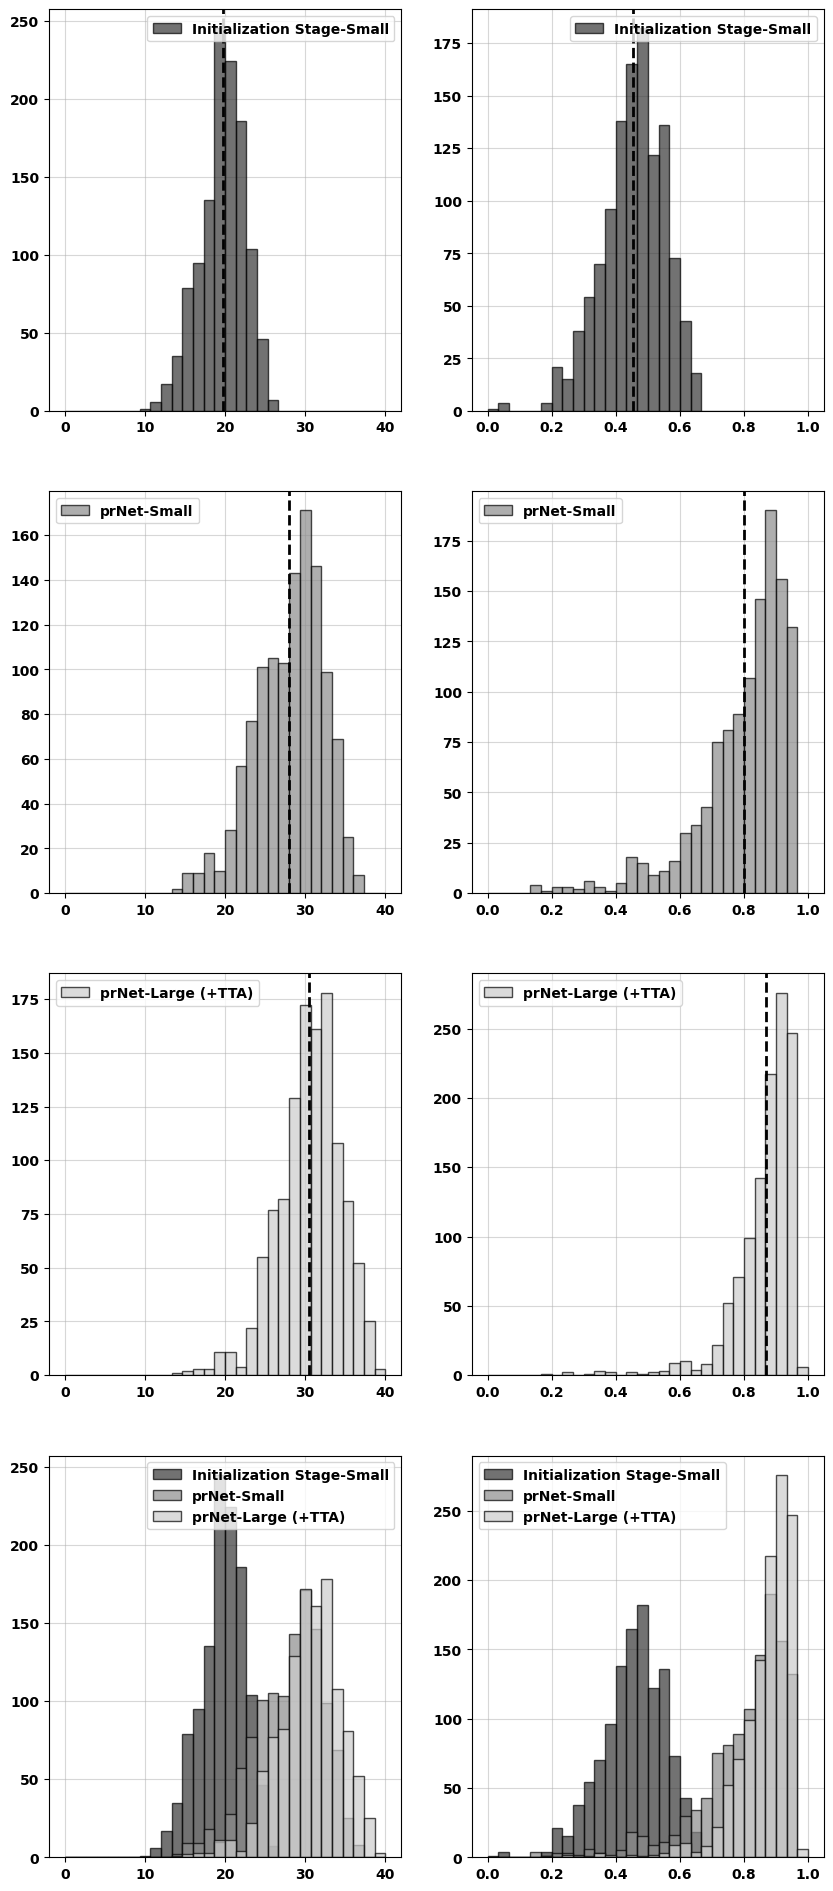

	 	 SSIM 	 || PSNR 	 || time (s)
Initialization Stage: 	 0.4549  || 19.6885 	 || 0.4703
Final Result: 	 0.8012  || 28.0211 	 || 1.0231
Final Result-Large: 	 0.8687  || 30.5328 	 || 1.8208


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch

psnr_hio       = np.array(np.concatenate([metrics['psnr_initialization_small'] for metrics in all_metrics]))
ssim_hio       = np.array(np.concatenate([metrics['ssim_initialization_small'] for metrics in all_metrics]))
t_hio          = np.array(np.concatenate([metrics['time_initialization_small'] for metrics in all_metrics]))

psnr_final     = np.array(np.concatenate([metrics['psnr_developed_small'] for metrics in all_metrics]))
ssim_final     = np.array(np.concatenate([metrics['ssim_developed_small'] for metrics in all_metrics]))
t_final        = np.array(np.concatenate([metrics['time_developed_small'] for metrics in all_metrics]))

psnr_large     = np.array(np.concatenate([metrics['psnr_developed_large_tta_mean'] for metrics in all_metrics]))
ssim_large     = np.array(np.concatenate([metrics['ssim_developed_large_tta_mean'] for metrics in all_metrics]))
t_large        = np.array(np.concatenate([metrics['time_developed_tta'] for metrics in all_metrics]))

plt.figure(figsize=[10,24])

plt.rcParams.update({'font.weight': 'bold'})
alpha = .7
linewidth = 1
linewidth_mean = 2
bins_psnr = 30
bins_ssim = 30

plt1 = plt.subplot(4,2,1)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_hio, bins=bins_psnr, range=(0,40), color='#363636', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage-Small'])
plt.axvline(psnr_hio.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,2)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_hio, bins=bins_ssim, range=(0,1), color='#363636', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage-Small'])
plt.axvline(ssim_hio.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,3)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_final, bins=bins_psnr, range=(0,40), color='#8c8c8c', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['prNet-Small'])
plt.axvline(psnr_final.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,4)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_final, bins=bins_ssim, range=(0,1), color='#8c8c8c', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['prNet-Small'])
plt.axvline(ssim_final.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,5)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_large, bins=bins_psnr, range=(0,40), color='#cccccc', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['prNet-Large (+TTA)'])
plt.axvline(psnr_large.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(4,2,6)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_large, bins=bins_ssim, range=(0,1), color='#cccccc', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['prNet-Large (+TTA)'])
plt.axvline(ssim_large.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

# all
plt1 = plt.subplot(4,2,7)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_hio, bins=bins_psnr, range=(0,40), color='#363636', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(psnr_final, bins=bins_psnr, range=(0,40), color='#8c8c8c', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(psnr_large, bins=bins_psnr, range=(0,40), color='#cccccc', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage-Small','prNet-Small','prNet-Large (+TTA)'])

plt1 = plt.subplot(4,2,8)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_hio, bins=bins_ssim, range=(0,1), color='#363636', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(ssim_final, bins=bins_ssim, range=(0,1), color='#8c8c8c', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(ssim_large, bins=bins_ssim, range=(0,1), color='#cccccc', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage-Small','prNet-Small','prNet-Large (+TTA)'])

# save figure as eps
plt.savefig('histogram_alpha3_large_small_new.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0)

plt.show()

print('\t \t SSIM \t || PSNR \t || time (s)')
print(f'Initialization Stage: \t {ssim_hio.mean():.4f}  || {psnr_hio.mean():.4f} \t || {t_hio.mean():.4f}')
print(f'Final Result: \t {ssim_final.mean():.4f}  || {psnr_final.mean():.4f} \t || {t_final.mean():.4f}')
print(f"Final Result-Large: \t {ssim_large.mean():.4f}  || {psnr_large.mean():.4f} \t || {t_large.mean():.4f}")